In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Get the current working directory (where your notebook is running)
script_dir = os.getcwd()

# Go one level up
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

# Insert the parent directory into Python path
sys.path.insert(0, parent_dir)
from models.linear_hp import hp_invert

In [13]:
def solve_rpm_and_eer(df):
    T_cond = df['outdoor_temp'].values
    load = df['load'].values

    rpm = [hp_invert(load[i], T_cond[i])[0] for i in range(len(load))]
    EER = [hp_invert(load[i], T_cond[i])[1] for i in range(len(load))]
    e = [hp_invert(load[i], T_cond[i])[2] for i in range(len(load))]

    return rpm, EER, e, load, T_cond


Results analysis

In [14]:
df_results_1H = pd.read_pickle('./results_1H.pkl')
df_results_15T = pd.read_pickle('./results_15T.pkl')
df_results_30T = pd.read_pickle('./results_30T.pkl')

In [15]:
baseline_15T = pd.read_pickle('./baseline_15T.pkl')
baseline_30T = pd.read_pickle('./baseline_30T.pkl')
baseline_1H = pd.read_pickle('./baseline_1H.pkl')

In [16]:
# For 15-minute resolution
date_index_15T = pd.date_range(start='2021-08-01 00:00:00', periods=len(df_results_15T), freq='15min')
df_results_15T.index = date_index_15T
df_results_15T['EER'] = df_results_15T['Q_cool'] * df_results_15T['EER'] / (df_results_15T['Q_cool'] + 1e-3)
df_results_15T['e_hp'] = df_results_15T['Q_cool'] * df_results_15T['e_hp'] / (df_results_15T['Q_cool'] + 1e-3)

# For 30-minute resolution
date_index_30T = pd.date_range(start='2021-08-01 00:00:00', periods=len(df_results_30T), freq='30min')
df_results_30T.index = date_index_30T
df_results_30T['EER'] = df_results_30T['Q_cool'] * df_results_30T['EER'] / (df_results_30T['Q_cool'] + 1e-3)
df_results_30T['e_hp'] = df_results_30T['Q_cool'] * df_results_30T['e_hp'] / (df_results_30T['Q_cool'] + 1e-3)

# For 1-hour resolution
date_index_1H = pd.date_range(start='2021-08-01 00:00:00', periods=len(df_results_1H), freq='1h')
df_results_1H.index = date_index_1H
df_results_1H['EER'] = df_results_1H['Q_cool'] * df_results_1H['EER'] / (df_results_1H['Q_cool'] + 1e-3)
df_results_1H['e_hp'] = df_results_1H['Q_cool'] * df_results_1H['e_hp'] / (df_results_1H['Q_cool'] + 1e-3)


In [17]:
for df in [baseline_15T, baseline_30T, baseline_1H]:
    # df['EER'] = df['load'] * df['EER'] / (df['load'] + 1e-3)
    df['e_hp'] = df['load'] * df['e_hp'] / (df['load'] + 1e-3)


In [18]:
baseline_e_hp = sum(baseline_15T.loc[date_index_15T, 'e_hp'] * baseline_15T.loc[date_index_15T, 'e_price'] * 0.001)
rl_e_hp = sum(df_results_15T['e_hp'] * df_results_15T['e_price'])

print(f'baseline: {baseline_e_hp}, rl: {rl_e_hp}')

baseline: 335.63502780700753, rl: 256.41564480196354


In [24]:
baseline_e_hp = baseline_15T.loc[date_index_15T, 'e_hp'].sum()
rl_e_hp = df_results_15T['e_hp'].sum()

print(f'baseline: {baseline_e_hp}, rl: {rl_e_hp}')

baseline: 2503.050806059121, rl: 2080.6986363481356


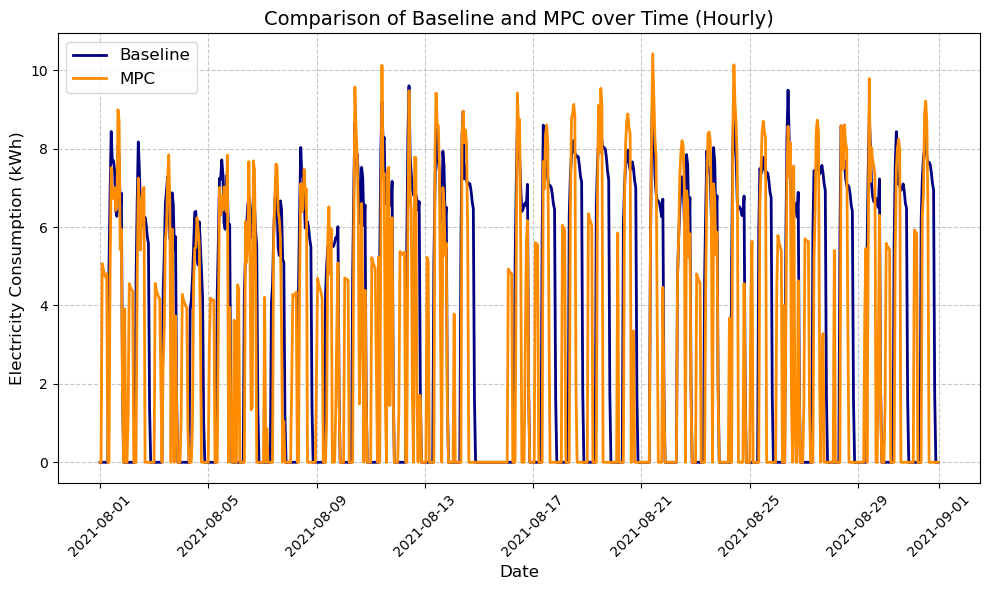

In [28]:
# Extract the relevant series with the electricity consumption values (kWh)
baseline_15T_val = baseline_15T.loc[date_index_15T, 'e_hp']
rl_mpc_val = df_results_15T['e_hp']

# Resample both series to hourly frequency:
# Here, we use sum to aggregate the 15-minute consumption into hourly consumption.
baseline_hourly = baseline_15T_val.resample('h').sum()
rl_mpc_hourly = rl_mpc_val.resample('h').sum()

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Plot the resampled baseline data
plt.plot(baseline_hourly.index, baseline_hourly, label='Baseline', color='navy', linewidth=2)

# Plot the resampled RL-MPC data
plt.plot(rl_mpc_hourly.index, rl_mpc_hourly, label='MPC', color='darkorange', linewidth=2)

# Add a title and labels to the plot
plt.title('Comparison of Baseline and MPC over Time (Hourly)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)

# Add a legend and grid lines for clarity
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# (Optional) If needed, rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

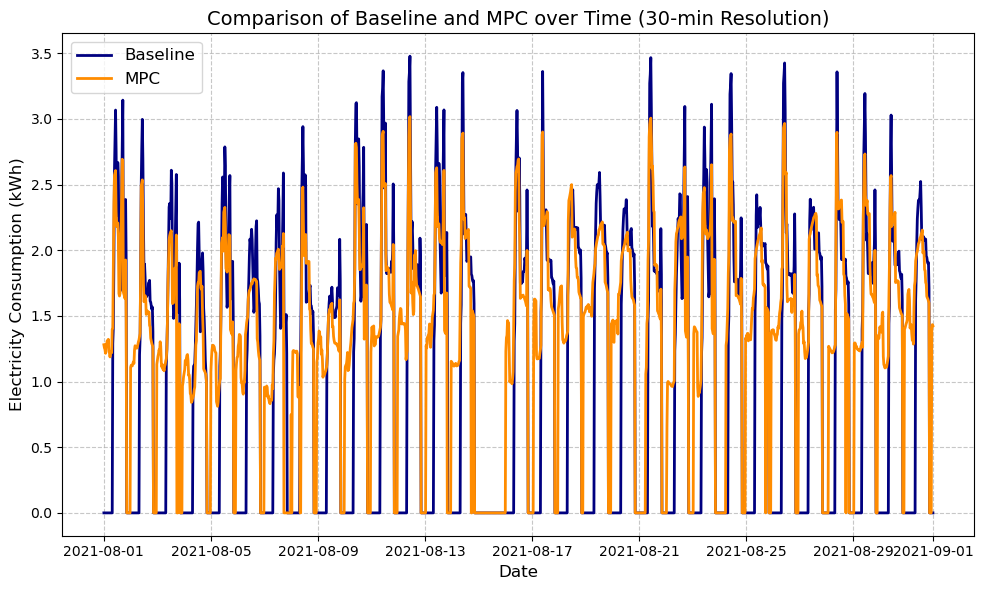

In [27]:
# Extract relevant data for 30-minute resolution
baseline_30T_val = baseline_30T.loc[date_index_30T, 'e_hp']
rl_mpc_val_30T = df_results_30T['e_hp']

baseline_hourly = baseline_30T_val.resample('h').sum()
rl_mpc_hourly = rl_mpc_val_30T.resample('h').sum()

# Create a figure for 30-minute resolution
plt.figure(figsize=(10, 6))

# Plot the baseline data
plt.plot(baseline_30T_val, label='Baseline', color='navy', linewidth=2)

# Plot the MPC data
plt.plot(rl_mpc_val_30T, label='MPC', color='darkorange', linewidth=2)

# Add title and axis labels
plt.title('Comparison of Baseline and MPC over Time (30-min Resolution)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)

# Add legend and grid
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


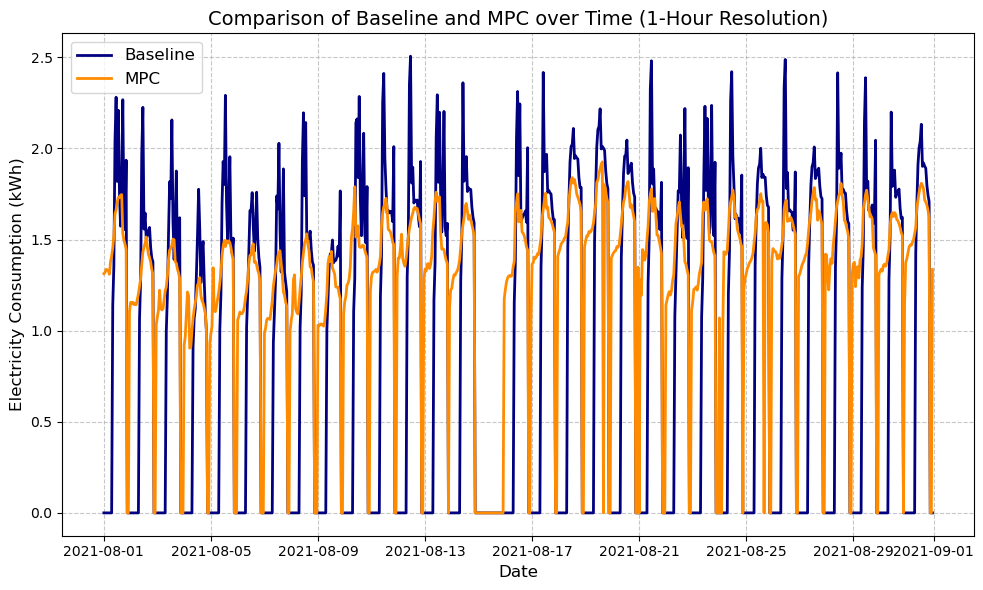

In [22]:
# Extract relevant data for 1-hour resolution
baseline_1H_val = baseline_1H.loc[date_index_1H, 'e_hp']
rl_mpc_val_1H = df_results_1H['e_hp']

# Create a figure for 1-hour resolution
plt.figure(figsize=(10, 6))

# Plot the baseline data
plt.plot(baseline_1H_val, label='Baseline', color='navy', linewidth=2)

# Plot the MPC data
plt.plot(rl_mpc_val_1H, label='MPC', color='darkorange', linewidth=2)

# Add title and axis labels
plt.title('Comparison of Baseline and MPC over Time (1-Hour Resolution)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)

# Add legend and grid
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [29]:
baseline_e_hp = baseline_15T.loc[date_index_15T, 'e_hp'].sum()
rl_e_hp = df_results_15T['e_hp'].sum()

print(f'baseline: {baseline_e_hp}, rl: {rl_e_hp}')

baseline: 2503.050806059121, rl: 2080.6986363481356


In [32]:
baseline_e_hp = baseline_1H.loc[date_index_1H, 'e_hp'].sum()
rl_e_hp = df_results_1H['e_hp'].sum()

print(f'baseline: {baseline_e_hp}, rl: {rl_e_hp}')

baseline: 663.332977342193, rl: 940.5616446637648


In [31]:
baseline_e_hp = baseline_30T.loc[date_index_30T, 'e_hp'].sum()
rl_e_hp = df_results_30T['e_hp'].sum()

print(f'baseline: {baseline_e_hp}, rl: {rl_e_hp}')

baseline: 1509.5565726050531, rl: 1991.922304066961
